In [55]:
import sys
import pandas as pd
import numpy as np
import sklearn as sk
import tensorflow as tf
import tensorflow.keras
print(f"TensorFlow version: {tf.__version__}")
print(f"Keras version: {tensorflow.keras.__version__}")
print(f"Python {sys.version}")
print(f"Pandas {pd.__version__}")
print(f"Scikit-Learn {sk.__version__}")
print(tf.config.list_physical_devices('GPU'))
import matplotlib.pyplot as plt
plt.style.use('dark_background')
from tensorflow.keras.backend import clear_session
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras import optimizers, datasets
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from sklearn.metrics import accuracy_score
from time import time

TensorFlow version: 2.4.1
Keras version: 2.4.0
Python 3.6.9 (default, Oct  8 2020, 12:12:24) 
[GCC 8.4.0]
Pandas 1.1.5
Scikit-Learn 0.22.2.post1
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [56]:
train = pd.read_json('train.json', lines=True)
test = pd.read_json('test.json', lines=True)
test.head()

,index,id,sequence,structure,predicted_loop_type,seq_length,seq_scored
0,0,id_00073f8be,GGAAAAGUACGACUUGAGUACGGAAAACGUACCAACUCGAUUAAAA...,......((((((((((.(((((.....))))))))((((((((......,EEEEEESSSSSSSSSSBSSSSSHHHHHSSSSSSSSSSSSSSSSHHH...,107,68
1,1,id_000ae4237,GGAAACGGGUUCCGCGGAUUGCUGCUAAUAAGAGUAAUCUCUAAAU...,.....((((..((((((...(((((.....((((....)))).......,EEEEESSSSIISSSSSSIIISSSSSIIIIISSSSHHHHSSSSIIII...,130,91
2,2,id_00131c573,GGAAAACAAAACGGCCUGGAAGACGAAGGAAUUCGGCGCGAAGGCC...,...........((.(((.(.(..((..((..((((...))))..))...,EEEEEEEEEEESSISSSISISIISSIISSIISSSSHHHSSSSIISS...,107,68
3,3,id_00181fd34,GGAAAGGAUCUCUAUCGAAGGAUAGAGAUCGCUCGCGACGGCACGA...,......((((((((((....))))))))))((((((..((.(((.....,EEEEEESSSSSSSSSSHHHHSSSSSSSSSSSSSSSSIISSISSSHH...,107,68
4,4,id_0020473f7,GGAAACCCGCCCGCGCCCGCCCGCGCUGCUGCCGUGCCUCCUCUCC...,.....(((((((((((((((((((((((((((((((((((((((((...,EEEEESSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS...,130,91


In [57]:
def process_seq(train):
    # processes les 3 sequences and the target
    seq = train.loc[:, 'sequence'].values
    struct = train.loc[:, 'structure'].values
    loop = train.loc[:, 'predicted_loop_type'].values
    y_train = train.loc[:, ['reactivity', 'deg_Mg_pH10', 'deg_pH10', 'deg_Mg_50C', 'deg_50C']]

    new_seq = []
    new_struct = []
    new_loop = []
    new_target = np.zeros([2400, 5, 68])

    for i in range(seq.shape[0]):
        # sequence processing
        seq_dic = {'A': 0, 'C': 1, 'G': 2, 'U': 3}
        n_seq = [seq_dic[l] for l in seq[i]]
        new_seq.append(n_seq)

        # structure processing
        struct_dic = {'(': 0, '.': 1, ')': 2}
        n_struct = [struct_dic[l] for l in struct[i]]
        new_struct.append(n_struct)

        # predicted_loop_type processing
        loop_dic = {'S':0, 'M':1, 'I':2, 'B':3, 'H':4, 'E':5, 'X':6}
        n_loop = [loop_dic[l] for l in loop[i]]
        new_loop.append(n_loop)

        # target processing
        new_target[i, :, :] = np.concatenate(y_train.values[i]).reshape(5, 68)

    return np.array(new_seq), np.array(new_struct), np.array(new_loop), new_target

seq, struct, loop, target = process_seq(train)

In [58]:
# reshape to concatenate last axis with the other features
seq = seq.reshape(seq.shape[0], seq.shape[1], 1) 
struct = struct.reshape(struct.shape[0], struct.shape[1], 1)
loop = loop.reshape(loop.shape[0], loop.shape[1], 1)
# (n_obs * seq_length * feature)
features = np.concatenate([seq, struct], axis=2)
print(features.shape)
print(target.shape)

(2400, 107, 2)
(2400, 5, 68)


In [60]:
# prepare data
# test data will only serve for sample submission.
# we have to split our train into train and valid
X_train = features
y_train = np.swapaxes(target, 1, 2)
train_size = int(len(X_train)*0.80)
# we take only the first 68 values of the seq
X_train, X_valid = X_train[:train_size, :68, :], X_train[train_size:, :68, :]
y_train, y_valid = y_train[:train_size, :68, :], y_train[train_size:, :68, :]
print(X_train.shape)
print(X_valid.shape)
print(y_train.shape)
print(y_valid.shape)

(1920, 68, 2)
(480, 68, 2)
(1920, 68, 5)
(480, 68, 5)


In [84]:
# create LSTM model
clear_session()

model = Sequential()
model.add(LSTM(units=50, 
               activation='tanh', 
               kernel_initializer='glorot_normal',  # xavier normal initialization
               return_sequences=True,
               input_shape=(X_train.shape[1], X_train.shape[2])))  # input shape = (68, 3)
model.add(Dropout(0.2))
model.add(LSTM(units=50, 
               activation='tanh', 
               return_sequences=True))
model.add(Dropout(0.2))
model.add(Dense(5, activation='relu'))  # output_shape = (68, 5)

model.compile(loss='mean_squared_error', optimizer='adam')
model.summary()

checkpoint_filepath = 'checkpoint_file'
checkpoint = ModelCheckpoint(filepath=checkpoint_filepath,
                             monitor='val_loss',
                             mode='min',
                             save_weights_only=True,
                             save_best_only=True)

history = model.fit(X_train, y_train, validation_data=(X_valid, y_valid), 
                    epochs=100, batch_size=128, verbose=1, callbacks=[checkpoint]) 

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 68, 50)            10600     
_________________________________________________________________
dropout (Dropout)            (None, 68, 50)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 68, 50)            20200     
_________________________________________________________________
dropout_1 (Dropout)          (None, 68, 50)            0         
_________________________________________________________________
dense (Dense)                (None, 68, 5)             255       
Total params: 31,055
Trainable params: 31,055
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
15/15 [==============================] - 3s 73ms/step - loss: 1.0004 - val_loss: 1.0745
Epoch 2/100
15/15 

15/15 [==============================] - 0s 3ms/step - loss: 0.9439
0.9438894391059875


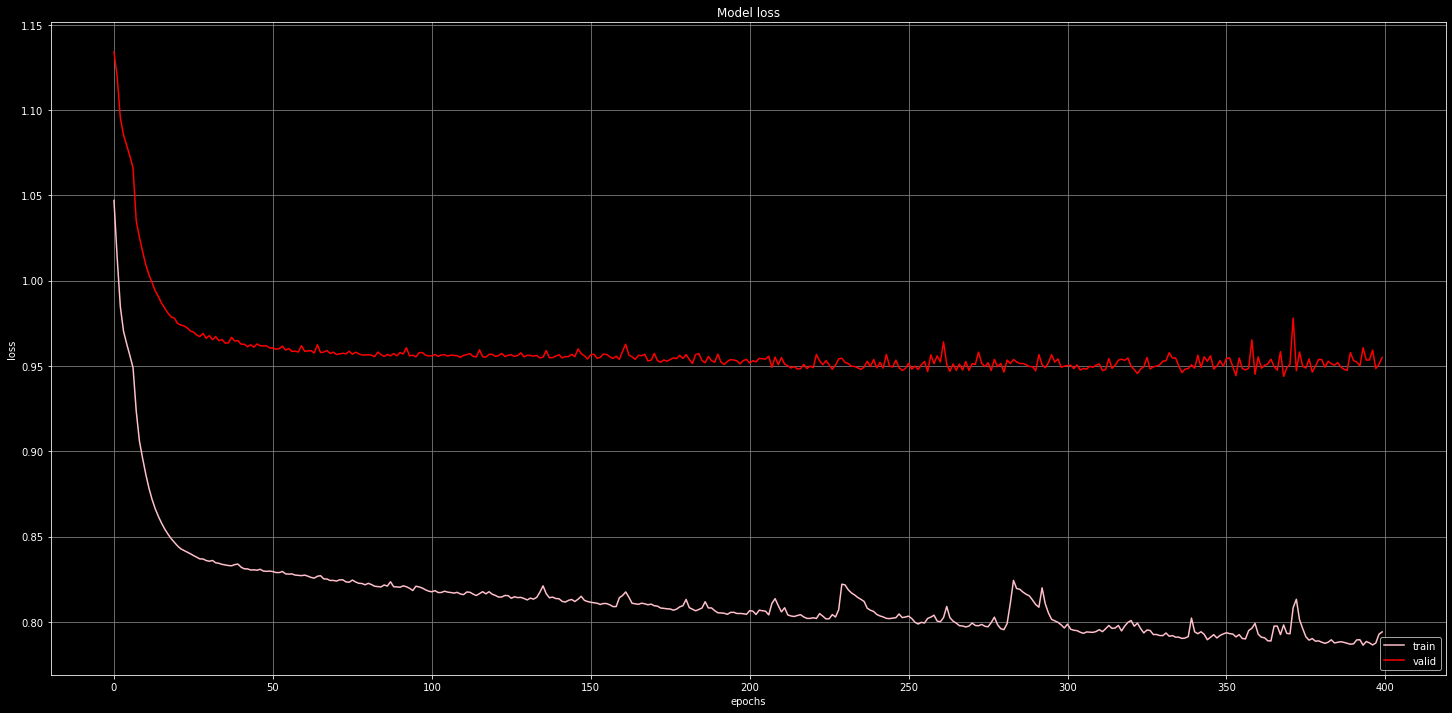

In [66]:
model.load_weights('checkpoint_file')  # load best model
mse = model.evaluate(X_valid, y_valid)
print(mse)

def plot_history(history):
    # plot history of CNN training
    plt.figure(figsize=(25, 12))
    plt.plot(history.history['loss'], color='pink', label='train')
    plt.plot(history.history['val_loss'], color='red', label='valid')
    plt.title('Model loss')
    plt.ylabel('loss')
    plt.xlabel('epochs')
    plt.legend(loc='lower right')
    plt.grid(color='grey')
    plt.show()

plot_history(history)

#model.predict(X_train[0,:,:])

In [81]:
model.predict(X_train)[0]

array([[0.5655458 , 0.5953725 , 2.0016396 , 0.4824934 , 0.5741792 ],
       [1.4976876 , 2.066843  , 2.9260724 , 2.042563  , 1.8419563 ],
       [1.1197884 , 0.7687284 , 0.91171384, 0.98218346, 1.0187368 ],
       [0.84447336, 0.61607164, 0.7569084 , 0.785345  , 0.7850028 ],
       [0.71273947, 0.71160704, 0.787045  , 0.85444957, 0.78006965],
       [0.31920537, 0.41196096, 0.46776763, 0.4659025 , 0.4901519 ],
       [0.19553861, 0.4697823 , 0.43931383, 0.35281512, 0.4771916 ],
       [0.09009606, 0.34417504, 0.32377672, 0.23362124, 0.3913712 ],
       [0.13723867, 0.3539289 , 0.25491253, 0.1802454 , 0.3377816 ],
       [0.01783507, 0.24341603, 0.18568239, 0.14365014, 0.26480648],
       [0.1109817 , 0.27238202, 0.14799237, 0.14480427, 0.22140983],
       [0.7121215 , 0.5416237 , 0.3896544 , 0.466851  , 0.5373431 ],
       [0.8126633 , 0.64248455, 0.51049036, 0.60101193, 0.6606075 ],
       [0.81671965, 0.82398164, 0.7067441 , 0.71813446, 0.7427177 ],
       [0.7580224 , 0.7022572 , 0.

In [ ]:
sample_sub = pd.read_csv('sample_submission.csv', sep=',')
rng = np.random.normal(2, 0.2, (457953, 5))
sample_sub.iloc[:, 1:] = rng
sample_sub[0:10]

,id_seqpos,reactivity,deg_Mg_pH10,deg_pH10,deg_Mg_50C,deg_50C
0,id_00073f8be_0,2.073513,1.951734,1.945810,2.033376,2.063232
1,id_00073f8be_1,2.029750,2.163283,2.214269,2.162002,2.028075
2,id_00073f8be_2,1.717368,2.061842,1.845021,1.852701,2.132514
3,id_00073f8be_3,2.010813,1.928485,2.069491,2.282164,2.418024
4,id_00073f8be_4,1.920599,1.974127,2.068043,1.729365,2.006571
5,id_00073f8be_5,2.151393,2.124969,1.759833,2.105465,2.151309
6,id_00073f8be_6,1.992442,1.954734,1.796370,2.089301,1.907396
7,id_00073f8be_7,2.029633,1.658533,1.672325,2.091965,1.790797
8,id_00073f8be_8,2.019208,2.221790,2.155620,2.106790,1.935207
9,id_00073f8be_9,2.112149,2.179876,2.180399,1.973199,2.149662


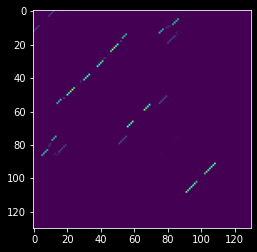

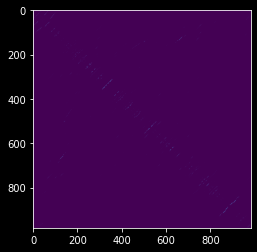

In [ ]:
data = np.load('id_000ae4237.npy')
data.shape
plt.imshow(data)
plt.show()
data1 = np.load('27.npy')
data1.shape
plt.imshow(data1)
plt.show()